#Project Big Data
####Jessica FORNETTI

### I) Mise en place de l’environnement de travail

####Installation de Spark

In [1]:
! apt-get update

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:6 http://security.ubuntu.com/ubuntu focal-security InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 108 

In [2]:
! apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
! wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

In [4]:
! tar xf /content/spark-3.3.2-bin-hadoop3.tgz

In [5]:
! pip install -q findspark
! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


####Création du SparkContext

In [6]:
# Set up required environment variables

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages org.apache.spark:spark-avro_2.11:2.4.5 pyspark-shell"

import findspark

findspark.init("spark-3.3.2-bin-hadoop3")


from pyspark import SparkContext, SparkConf

configuration = SparkConf().setAppName("project").setMaster("local[4]")
sc = SparkContext(conf=configuration)

####Création du SparkSession

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.config(conf=configuration).getOrCreate()

###II) Les données

####Téléchargement des données


In [8]:
! wget -q http://qwone.com/~jason/20Newsgroups/20news-19997.tar.gz

####Décompression des données


In [9]:
! tar xf /content/20news-19997.tar.gz

####Chargement des données dans deux RDDs

In [10]:
rdd1 = sc.wholeTextFiles("/content/20_newsgroups/alt.atheism")

rdd2 = sc.wholeTextFiles("/content/20_newsgroups/rec.sport.baseball")

####Séparation du corps du message et de l’entête

In [11]:
def f(x):
  a = x[0]
  b = x[1].split("\n\n", 1) #on fait le split uniquement sur la 1ere occurence de \n\n
  return [a, b]


rdd1 = rdd1.map(lambda x: list(x)).map(f)
rdd1.first()

['file:/content/20_newsgroups/alt.atheism/51169',
 ['Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51169 soc.motss:139998 rec.scouting:5327\nNewsgroups: alt.atheism,soc.motss,rec.scouting\nPath: cantaloupe.srv.cs.cmu.edu!rochester!cornell!batcomputer!caen!nic.umass.edu!umassd.edu!ulowell!ulowell.ulowell.edu!jvigneau\nFrom: jvigneau@cs.ulowell.edu (Joe Vigneau)\nSubject: Re: [soc.motss, et al.] "Princeton axes matching funds for Boy Scouts"\nIn-Reply-To: bevans@carina.unm.edu\'s message of 4 Apr 1993 12:19:20 GMT\nMessage-ID: <JVIGNEAU.93Apr5182106@cs.ulowell.edu>\nSender: usenet@ulowell.ulowell.edu (News manager - ulowell)\nOrganization: -\nReferences: <merlyn.733766717@digibd> <1pijfo$1l4@fido.asd.sgi.com>\n\t<1993Apr3.214557.24073@midway.uchicago.edu> <1pmjo8INN2l0@lynx.unm.edu>\nDate: Mon, 5 Apr 1993 23:21:06 GMT\nLines: 21',
  "In article <1pmjo8INN2l0@lynx.unm.edu> bevans@carina.unm.edu (Mathemagician) writes:\n\n   Just what do gay people do that straight people don't?\n\nAbsolutel

In [12]:
rdd2 = rdd2.map(lambda x: list(x)).map(f)
rdd2.first()

['file:/content/20_newsgroups/rec.sport.baseball/102734',
 ['Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!ogicse!network.ucsd.edu!usc!wupost!cs.uiuc.edu!pegasus.cs.uiuc.edu!steph\nFrom: steph@pegasus.cs.uiuc.edu (Dale Stephenson)\nNewsgroups: rec.sport.baseball\nSubject: "Seer" Stephenson picks the A.L. East\nSummary: The division has gone to the birds\nKeywords: last chance for foolishness\nMessage-ID: <steph.733989466@pegasus.cs.uiuc.edu>\nDate: 5 Apr 93 05:57:46 GMT\nArticle-I.D.: pegasus.steph.733989466\nSender: news@cs.uiuc.edu\nOrganization: University of Illinois, Dept. of Comp. Sci., Urbana, IL\nLines: 95',
  'Having run completely out of time, I\'ve got to get my prophesies and\npredictions for the A.L. out.  Qualifications -- one of the worse\nfinishes in last year\'s prediction contest.\n\nAL East -- 1993\n\n1.  Baltimore Orioles\nWhy the Orioles?  Well, I pondered long and hard, and it all came down to\nthis:\n  -- The Blue Jays are going the wrong direction.\n  -- 

####Extraction des champs organisation et catégorie



Les champs sont ajoutés a la fin de la liste.
On a [filepath, [header, body], categorie, organisation]

In [13]:
def SplitCategory(x):
  a = x[1][0].split("Newsgroups:", 1)
  b = a[1].split("\n", 1)
  x.append(b[0])
  return x

def SplitOrganization(x):
  a = x[1][0].split("Organization:", 1)

  if(a == [x[1][0]]):
    x.append("null")  #il n'y a pas toujours un champs organisation 
  else:
    b = a[1].split("\n", 1)
    x.append(b[0])
  
  return x

rdd1 = rdd1.map(SplitCategory).map(SplitOrganization)
rdd1.take(5)

[['file:/content/20_newsgroups/alt.atheism/51169',
  ['Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51169 soc.motss:139998 rec.scouting:5327\nNewsgroups: alt.atheism,soc.motss,rec.scouting\nPath: cantaloupe.srv.cs.cmu.edu!rochester!cornell!batcomputer!caen!nic.umass.edu!umassd.edu!ulowell!ulowell.ulowell.edu!jvigneau\nFrom: jvigneau@cs.ulowell.edu (Joe Vigneau)\nSubject: Re: [soc.motss, et al.] "Princeton axes matching funds for Boy Scouts"\nIn-Reply-To: bevans@carina.unm.edu\'s message of 4 Apr 1993 12:19:20 GMT\nMessage-ID: <JVIGNEAU.93Apr5182106@cs.ulowell.edu>\nSender: usenet@ulowell.ulowell.edu (News manager - ulowell)\nOrganization: -\nReferences: <merlyn.733766717@digibd> <1pijfo$1l4@fido.asd.sgi.com>\n\t<1993Apr3.214557.24073@midway.uchicago.edu> <1pmjo8INN2l0@lynx.unm.edu>\nDate: Mon, 5 Apr 1993 23:21:06 GMT\nLines: 21',
   "In article <1pmjo8INN2l0@lynx.unm.edu> bevans@carina.unm.edu (Mathemagician) writes:\n\n   Just what do gay people do that straight people don't?\n\nAbsolu

In [14]:
rdd2 = rdd2.map(SplitCategory).map(SplitOrganization)
rdd2.take(5)

[['file:/content/20_newsgroups/rec.sport.baseball/102734',
  ['Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!ogicse!network.ucsd.edu!usc!wupost!cs.uiuc.edu!pegasus.cs.uiuc.edu!steph\nFrom: steph@pegasus.cs.uiuc.edu (Dale Stephenson)\nNewsgroups: rec.sport.baseball\nSubject: "Seer" Stephenson picks the A.L. East\nSummary: The division has gone to the birds\nKeywords: last chance for foolishness\nMessage-ID: <steph.733989466@pegasus.cs.uiuc.edu>\nDate: 5 Apr 93 05:57:46 GMT\nArticle-I.D.: pegasus.steph.733989466\nSender: news@cs.uiuc.edu\nOrganization: University of Illinois, Dept. of Comp. Sci., Urbana, IL\nLines: 95',
   'Having run completely out of time, I\'ve got to get my prophesies and\npredictions for the A.L. out.  Qualifications -- one of the worse\nfinishes in last year\'s prediction contest.\n\nAL East -- 1993\n\n1.  Baltimore Orioles\nWhy the Orioles?  Well, I pondered long and hard, and it all came down to\nthis:\n  -- The Blue Jays are going the wrong direction.\n  

####Fusion des deux RDDs


In [15]:
rdd = rdd1.union(rdd2)
#rdd.first()
#rdd.take(50)
rdd.count()

2000

####On rajoute les champs Date, Subject et Lines

####De plus, pour faciliter la conversion de chaque élément en pyspark.sql.Row, on ajoute chque champs a la suite dans une liste simple :     [filepath, header, body, categorie, organisation, date, sujet, lines] 

In [16]:
rdd1 = sc.wholeTextFiles("/content/20_newsgroups/alt.atheism")
rdd2 = sc.wholeTextFiles("/content/20_newsgroups/rec.sport.baseball")

def f(x):
  a = x[0]
  b = x[1].split("\n\n", 1) #on fait le split uniquement sur la 1ere occurence de \n\n
  return [a, b[0], b[1]]

def SplitCategory(x):
  a = x[1].split("Newsgroups:", 1)
  b = a[1].split("\n", 1)
  x.append(b[0])
  return x

def SplitOrganization(x):
  a = x[1].split("Organization:", 1)

  if(a == [x[1]]):
    x.append("null") #il n'y a pas toujours un champs organisation
  else:
    b = a[1].split("\n", 1)
    x.append(b[0])
  
  return x

def SplitDate(x):
  a = x[1].split("Date:", 1)

  if(a == [x[1]]):
    x.append("null")
  else:
    b = a[1].split("\n", 1)
    x.append(b[0])
  
  return x

def SplitSubject(x):
  a = x[1].split("Subject:", 1)

  if(a == [x[1]]):
   x.append("null")
  else:
    b = a[1].split("\n", 1)
    x.append(b[0])
  
  return x

def SplitLines(x):
  a = x[1].split("Lines:", 1)

  if(a == [x[1]]):
   x.append("null")
  else:
    b = a[1].split("\n", 1)
    x.append(b[0])
  
  return x

rdd1 = rdd1.map(lambda x: list(x)).map(f).map(SplitCategory).map(SplitOrganization).map(SplitDate).map(SplitSubject).map(SplitLines)
rdd2 = rdd2.map(lambda x: list(x)).map(f).map(SplitCategory).map(SplitOrganization).map(SplitDate).map(SplitSubject).map(SplitLines)

rdd = rdd1.union(rdd2)
#rdd.take(5)
rdd.count()

2000

####Création de l'objet de type DataFrame à partir du RDD précédent


In [17]:
rdd = rdd.map(lambda x : tuple(x))

columns = ["file_id", "header", "body", "category", "organization", "date", "subject", "nbLines"]
df = spark.createDataFrame(data=rdd, schema = columns)

#df.printSchema()
#df.show(truncate=False) #pour voir la totalite de chaque champs
df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|             file_id|              header|                body|            category|        organization|                date|             subject|nbLines|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------+
|file:/content/20_...|Xref: cantaloupe....|In article <1pmjo...| alt.atheism,soc....|                   -| Mon, 5 Apr 1993 ...| Re: [soc.motss, ...|     21|
|file:/content/20_...|Path: cantaloupe....|(reference line t...|         alt.atheism| California Insti...| 3 Apr 93 00:51:1...| Re: <Political A...|     62|
|file:/content/20_...|Xref: cantaloupe....|student writes:\n...| alt.atheism,soc....|           Summit NJ| 6 Apr 93 04:13:4...| Re: [soc.motss, ...|     39|
|file:/content/20_...|Xref: cantaloupe....|watson@sce.carl

###III) Analyse descriptive

####Vérification qu’on a bien deux catégories différentes de documents

In [18]:
from pyspark.sql.functions import sum, col, desc, mean, min, max

df.groupBy("category").count().sort(desc("count")).show(37, truncate=False)


+---------------------------------------------------------------------------------+-----+
|category                                                                         |count|
+---------------------------------------------------------------------------------+-----+
| rec.sport.baseball                                                              |981  |
| alt.atheism                                                                     |734  |
| talk.abortion,alt.atheism,talk.religion.misc                                    |94   |
| alt.atheism,talk.religion.misc,talk.origins                                     |92   |
| alt.atheism,talk.religion.misc                                                  |20   |
| alt.atheism,soc.motss,rec.scouting                                              |8    |
| sci.skeptic,alt.atheism                                                         |7    |
| alt.atheism,alt.atheism.moderated,news.answers,alt.answers                      |7    |
| rec.spor

On voit que les 2 catégories les plus fréquentes sont rec.sport.baseball et alt.atheism. Comme certain documents appartiennent à plusieurs categories différentes en même temps, on peut considerer qu'il y a uniquement 2 catégories 

In [19]:
df.filter(col("category").contains("alt.atheism")).count()

1000

In [20]:
df.filter(col("category").contains("rec.sport.baseball")).count()

1000

(On retrouve bien 2000, le nombre total de documents dans la collection)

####Nombre d'organisations différentes

In [21]:
#On a les 50 premieres organisations différentes rangées dans l'ordre décroissant
df.groupBy("organization").count().sort(desc("count")).show(50, truncate=False) 

+-------------------------------------------------------------------------------+-----+
|organization                                                                   |count|
+-------------------------------------------------------------------------------+-----+
| sgi                                                                           |70   |
| California Institute of Technology, Pasadena                                  |65   |
|null                                                                           |63   |
| Siemens-Nixdorf AG                                                            |41   |
| Mantis Consultants, Cambridge. UK.                                            |40   |
| Case Western Reserve University                                               |39   |
| Technical University Braunschweig, Germany                                    |35   |
| Okcforum Unix Users Group                                                     |32   |
| University of Illinois at Urba

Il y a 485 organisation différentes en tout (486-1 car les valeurs null sont comptées comme une catégorie):

In [22]:
l = df.groupBy("organization").count()
l.count() # on compte le nombre de ligne du dataframe l

486

####Les dates

On s'interesse aux dates:

In [23]:
df.groupBy("date").count().sort(desc("count")).show(truncate=False)

+--------------------------------+-----+
|date                            |count|
+--------------------------------+-----+
| Mon, 26 Apr 1993 14:07:43 GMT  |2    |
| Mon, 19 Apr 1993 03:37:10 GMT  |1    |
| 15 Apr 93 22:34:57 GMT         |1    |
| Tue, 6 Apr 1993 07:28:16 GMT   |1    |
| 14 Apr 1993 08:42:51 -0500     |1    |
| 20 Apr 93 22:40:40 GMT         |1    |
| 6 Apr 1993 16:43:35 GMT        |1    |
| 6 Apr 93 06:32:25 GMT          |1    |
| Tue, 20 Apr 1993 18:13:59 GMT  |1    |
| 20 Apr 93 19:11:44 -0600       |1    |
| Tue, 20 Apr 1993 02:17:29 GMT  |1    |
| 21 Apr 1993 21:29:27 GMT       |1    |
| 25 Apr 93 11:26:11 EST         |1    |
| 22 Apr 1993 20:52:13 GMT       |1    |
| 16 Apr 93 00:14:51 GMT         |1    |
| 26 Apr 1993 14:25:34 GMT       |1    |
| Thu, 22 Apr 1993 00:50:03 GMT  |1    |
| 23 Apr 93 23:07:34 GMT         |1    |
| Wed, 21 Apr 1993 12:00:12 +0100|1    |
| Thu, 22 Apr 1993 00:01:01 GMT  |1    |
+--------------------------------+-----+
only showing top

On consatate que tous les documents proviennent de l'année 1993 et du mois d'avril 

In [24]:
a = df.filter(col("date").contains("1993"))
a.count()

1373

In [25]:
b = df.filter(col("date").contains(" 93"))
b.count()

627

In [26]:
c = df.filter(col("date").contains("Apr"))
c.count()

1989

On s'interessse donc au nombre de documents par jour :

In [27]:
for i in range(1, 31):
  a = df.filter(col("date").contains(" "+str(i)+" "))
  print("Day " + str(i) + " : " + str(a.count()))



Day 1 : 3
Day 2 : 16
Day 3 : 13
Day 4 : 10
Day 5 : 117
Day 6 : 196
Day 7 : 2
Day 8 : 0
Day 9 : 0
Day 10 : 0
Day 11 : 2
Day 12 : 2
Day 13 : 3
Day 14 : 9
Day 15 : 235
Day 16 : 333
Day 17 : 60
Day 18 : 38
Day 19 : 65
Day 20 : 301
Day 21 : 251
Day 22 : 56
Day 23 : 199
Day 24 : 25
Day 25 : 14
Day 26 : 37
Day 27 : 5
Day 28 : 1
Day 29 : 1
Day 30 : 1


On voit que les jours ayant le plus de documents sont le 16, 20, 21 et 15, alors que le 8, 9 et 10 n'ont aucun document

####Nombre de lignes

On a le nombre de lignes avec le plus d'occurences: 19 lignes

In [28]:
df.groupBy("nbLines").count().sort(desc("count")).show(truncate=False)

+-------+-----+
|nbLines|count|
+-------+-----+
| 19    |74   |
| 20    |60   |
| 15    |59   |
| 21    |59   |
| 18    |59   |
| 12    |57   |
| 16    |56   |
| 17    |56   |
| 14    |56   |
| 23    |55   |
| 26    |50   |
| 28    |49   |
| 13    |48   |
| 22    |46   |
| 24    |43   |
| 31    |40   |
| 11    |39   |
| 9     |38   |
| 33    |38   |
| 30    |37   |
+-------+-----+
only showing top 20 rows



Le document ayant le plus de lignes a 99 lignes

In [29]:
df.groupBy("nbLines").count().sort(desc("nbLines")).show(truncate=False)

+-------+-----+
|nbLines|count|
+-------+-----+
|null   |6    |
| 99    |1    |
| 98    |3    |
| 97    |2    |
| 96    |4    |
| 95    |2    |
| 94    |2    |
| 93    |5    |
| 92    |1    |
| 91    |1    |
| 9     |38   |
| 89    |5    |
| 88    |5    |
| 87    |4    |
| 86    |2    |
| 85    |2    |
| 84    |1    |
| 83    |3    |
| 81    |2    |
| 80    |6    |
+-------+-----+
only showing top 20 rows



Les documents ont en moyenne 36,48 lignes

In [30]:
df.select(mean("nbLines")).show()

+-----------------+
|     avg(nbLines)|
+-----------------+
|36.48294884653962|
+-----------------+



On installe la librairie pyspark_dist_explore pour pouvoir afficher l'histogramme pour la colone nombre de lignes

In [31]:
!pip install pyspark_dist_explore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


On obtient l'histogramme suivant:

(array([243., 584., 451., 256., 152.,  84.,  54.,  37.,  29.,  21.,  12.,
         17.,   8.,   7.,   4.,   4.,   2.,   4.,   4.,   3.,   1.,   2.,
          2.,   2.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([1.00000e+00, 1.14800e+01, 2.19600e+01, 3.24400e+01, 4.29200e+01,
        5.34000e+01, 6.38800e+01, 7.43600e+01, 8.48400e+01, 9.53200e+01,
        1.05800e+02, 1.16280e+02, 1.26760e+02, 1.37240e+02, 1.47720e+02,
        1.58200e+02, 1.68680e+02, 1.79160e+02, 1.89640e+02, 2.00120e+02,
        2.10600e+02, 2.210

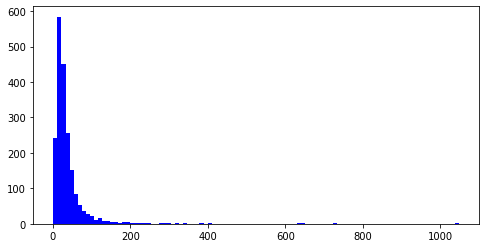

In [32]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

changedTypedf = df.withColumn("nbLines", df["nbLines"].cast("double"))

fig, ax = plt.subplots(figsize=(8,4))
hist(ax, changedTypedf.select("nbLines"), bins = 100, color=['blue'])

###IV) Transformation du texte

####Découpage des documents en listes de mots à l’aide de Tokenizer

In [33]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

rdd1 = sc.wholeTextFiles("/content/20_newsgroups/alt.atheism")
rdd2 = sc.wholeTextFiles("/content/20_newsgroups/rec.sport.baseball")
rdd = rdd1.union(rdd2)

columns = ["id", "document"]
df = spark.createDataFrame(data=rdd, schema = columns)

tokenizer = Tokenizer(inputCol="document", outputCol="words")
wordsData = tokenizer.transform(df)

####Création d'une représentation vectorielle des documents à l’aide de HashingTF


Pour que la fonction hashingTF marche bien (qu'il y ait le moins de collisions possible),  il faut prendre un nombre de features plus élevé que la taille du vocabulaire

En moyenne on a 36 lignes par document, si on considère qu'il y a 15 mots par lignes cela fait 540 mots.
Il faut aussi prendre en considération qu'il y a des répétition de mots et que certains documents ont presque une centaine de lignes.


Donc on chosit 3000

In [34]:
hashingTF = HashingTF(inputCol="words", outputCol="features", numFeatures=3000)
featurizedData = hashingTF.transform(wordsData)

featurizedData.select("id", "features").show(20, 50)

+---------------------------------------------+--------------------------------------------------+
|                                           id|                                          features|
+---------------------------------------------+--------------------------------------------------+
|file:/content/20_newsgroups/alt.atheism/51169|(3000,[17,54,66,84,113,131,139,145,183,198,231,...|
|file:/content/20_newsgroups/alt.atheism/51162|(3000,[8,17,18,23,31,34,42,52,54,64,66,71,73,13...|
|file:/content/20_newsgroups/alt.atheism/51224|(3000,[17,31,54,66,73,76,110,120,131,132,133,13...|
|file:/content/20_newsgroups/alt.atheism/54184|(3000,[12,17,23,26,43,46,53,54,109,118,121,139,...|
|file:/content/20_newsgroups/alt.atheism/51310|(3000,[15,17,24,54,139,145,148,177,201,261,263,...|
|file:/content/20_newsgroups/alt.atheism/53561|(3000,[2,5,17,23,37,46,54,66,84,107,120,135,139...|
|file:/content/20_newsgroups/alt.atheism/54251|(3000,[12,15,17,54,58,116,133,139,145,263,289,3...|
|file:/con

###V) Grouper les documents qui ont des représentations vectorielles proches





####KMeans

In [35]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model
#On prend k = 2 clusters
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(featurizedData)

# Make predictions
predictions = model.transform(featurizedData)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.996158234766001
Cluster Centers: 
[0.08471178 0.02907268 0.03558897 ... 0.03308271 0.05263158 0.02556391]
[0.8 0.4 0.  ... 0.6 1.  0.6]


**On obtient un score Silhouette de 0.99616, ce qui est très proche de 1. Cela veut donc dire que les documents ont été rangés dans le bon cluster**

###VI)  Pour aller plus loin

####Pondérer les mots avec la formule Tf-Idf (avant KMeans)

In [36]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

rdd1 = sc.wholeTextFiles("/content/20_newsgroups/alt.atheism")
rdd2 = sc.wholeTextFiles("/content/20_newsgroups/rec.sport.baseball")
rdd = rdd1.union(rdd2)

columns = ["id", "document"]
df = spark.createDataFrame(data=rdd, schema = columns)

tokenizer = Tokenizer(inputCol="document", outputCol="words")
wordsData = tokenizer.transform(df)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=3000) #On prend 3000 comme précédemment
featurizedData = hashingTF.transform(wordsData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("id", "features").show(20, 50)

+---------------------------------------------+--------------------------------------------------+
|                                           id|                                          features|
+---------------------------------------------+--------------------------------------------------+
|file:/content/20_newsgroups/alt.atheism/51169|(3000,[17,54,66,84,113,131,139,145,183,198,231,...|
|file:/content/20_newsgroups/alt.atheism/51162|(3000,[8,17,18,23,31,34,42,52,54,64,66,71,73,13...|
|file:/content/20_newsgroups/alt.atheism/51224|(3000,[17,31,54,66,73,76,110,120,131,132,133,13...|
|file:/content/20_newsgroups/alt.atheism/54184|(3000,[12,17,23,26,43,46,53,54,109,118,121,139,...|
|file:/content/20_newsgroups/alt.atheism/51310|(3000,[15,17,24,54,139,145,148,177,201,261,263,...|
|file:/content/20_newsgroups/alt.atheism/53561|(3000,[2,5,17,23,37,46,54,66,84,107,120,135,139...|
|file:/content/20_newsgroups/alt.atheism/54251|(3000,[12,15,17,54,58,116,133,139,145,263,289,3...|
|file:/con

In [37]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(rescaledData)

# Make predictions
predictions = model.transform(rescaledData)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.8877214786525272
Cluster Centers: 
[0.19992392 0.09666459 0.11789873 ... 0.10376763 0.14577345 0.08986133]
[1.28218566 0.50833587 0.51343845 ... 0.78358802 1.06097609 0.5328859 ]


On constate qu'on obtient un score de 0.8877, toujours proche de 1 mais pire que le score précédent. Cela semble bizarre car normalement en donnant moins d'importance aux mots communs cela devrait améliorer le resultat du Kmeans